# Supervised Learning of Actions - Neural Network
We fit a Neural Net to the Sepsis data in this note

In [30]:
import pandas as pd
import numpy as np
from tqdm import tqdm
exportdir='/data/localhost/taufiq/export-dir/'

In [2]:
import logging
logging.basicConfig(filename='neural-net.log', level=logging.INFO)

In [3]:
nra = 5

## Import Data

In [50]:
MIMICraw = pd.read_csv(exportdir + 'MIMICraw-logistic_reg-1hourly.csv')
MIMICraw.head()

,gender,mechvent,re_admission,age,Weight_kg,GCS,HR,SysBP,MeanBP,DiaBP,...,Creatinine,SGOT,SGPT,Total_bili,INR,output_total,output_1hourly,last_input,total_input_before,last_vaso_dose
0,-0.5,-0.5,0.5,-0.188164,0.977001,0.373302,-0.575778,-0.480229,0.084172,-0.029420,...,-0.258526,4.799837,5.034709,2.516924,-0.692710,0.248210,0.323737,-0.466274,-0.713778,-0.50
1,-0.5,-0.5,0.5,-0.188164,0.645357,0.673538,-0.934044,-0.255514,-0.047822,0.309388,...,-1.255075,-1.151380,-0.792918,-0.711890,0.538002,0.380034,0.315833,1.833942,1.404393,-0.32
2,-0.5,-0.5,-0.5,-1.051718,-0.629896,-0.827640,-0.410425,-0.098214,0.249165,0.444911,...,0.592298,0.646722,0.730208,1.169624,0.160168,0.338320,0.417525,-0.466274,-0.713778,-0.50
3,-0.5,-0.5,-0.5,-1.051718,-0.140325,-0.827640,-0.465543,-0.233043,0.183168,0.377150,...,-0.993943,-0.561408,-0.114526,-0.386553,-0.925742,0.469704,0.409959,-0.466274,1.493079,-0.50
4,-0.5,-0.5,-0.5,0.012852,-0.329836,0.673538,0.002959,-0.412815,-0.608798,-0.673156,...,-0.993943,-0.149953,-0.300658,-1.205811,0.538002,0.290199,0.369480,-0.466274,-0.713778,-0.50


In [5]:
MIMICtable = pd.read_csv(exportdir + 'MIMIC-1hourly-length-2.csv')
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,65537,7.139723e+09,0.0,22799.404780,4.0,1.0,0.0,0.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267
1,2,65537,7.139727e+09,0.0,22799.404780,4.0,1.0,0.0,0.0,0.0,...,0.0,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600
2,1,3,7.245400e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.663900,599.999991,0.00,0.00,6267.000000,0.000000,9490.0,4705.0,-3223.000000
3,2,3,7.245403e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.672340,339.999995,0.00,0.00,6267.000000,10.000000,14095.0,4605.0,-7818.000000
4,1,65544,7.056917e+09,0.0,24000.436400,3.0,0.0,0.0,0.0,0.0,...,0.0,0.770925,938.636364,0.00,0.00,11332.000000,0.000000,8210.0,4105.0,3122.000000


## Create Actions

In [6]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable.loc[MIMICtable['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_1hourly'].median(), MIMICtable.loc[io==2, 'input_1hourly'].median(), MIMICtable.loc[io==3, 'input_1hourly'].median(), MIMICtable.loc[io==4, 'input_1hourly'].median(), MIMICtable.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [18]:
actionbloc.head()

,action_bloc
0,0
1,1
2,2
3,3
4,2


## Create Training and Test data

In [51]:
icuuniqueids = MIMICtable['icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = MIMICraw.loc[MIMICtable['icustay_id'].isin(trainidx)]
Xtestmimic = MIMICraw[MIMICtable['icustay_id'].isin(testidx)]
blocs = MIMICtable.loc[MIMICtable['icustay_id'].isin(trainidx), 'bloc']
bloctestmimic = MIMICtable.loc[MIMICtable['icustay_id'].isin(testidx), 'bloc']
ptid = MIMICtable.loc[MIMICtable['icustay_id'].isin(trainidx), 'icustay_id']
ptidtestmimic = MIMICtable.loc[MIMICtable['icustay_id'].isin(testidx), 'icustay_id']
Y = actionbloc.loc[MIMICtable['icustay_id'].isin(trainidx), 'action_bloc']
Ytest = actionbloc.loc[MIMICtable['icustay_id'].isin(testidx), 'action_bloc']


## Define the Neural Network Architecture

In [52]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Mnist_Logistic(nn.Module):
    def __init__(self, input_dim, output_dim=nact):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, 60)
        self.lin2 = nn.Linear(60, 60)
        self.lin3 = nn.Linear(60, 60)
        self.lin4 = nn.Linear(60, output_dim)

    def forward(self, xb):
        xb = F.leaky_relu(self.lin1(xb))
        xb = F.leaky_relu(self.lin2(xb))
        xb = F.leaky_relu(self.lin3(xb))
        xb = F.softmax(self.lin3(xb), dim=1)
        return xb
    

loss_func = F.cross_entropy        

In [53]:
def get_model():
    global X
    model = Mnist_Logistic(input_dim = X.size(1))
    return model, optim.SGD(model.parameters(), lr=0.001)

In [54]:
X, Y, Xtestmimic, Ytest = map(torch.tensor, (X.values, Y.values, Xtestmimic.values, Ytest.values))

In [55]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_ds = TensorDataset(X, Y)
train_dl = DataLoader(train_ds, batch_size=32)

test_ds = TensorDataset(Xtestmimic, Ytest)
test_dl = DataLoader(test_ds, batch_size=32)


## Training

In [56]:
def accuracy(dataloader):
    global model
    matches = 0
    for xb, yb in dataloader:
        _, predicted = torch.max(model(xb.float()), 1)
        matches += (predicted == yb).sum()
    return (matches.float()/len(dataloader.dataset)).item()

In [57]:
model, opt = get_model()
test_loss = []
test_acc = []
train_acc = []
logging.info('Starting training')

for epoch in tqdm(range(1000)):
    logging.info('Epoch: ' + str(epoch))
    model.train()
    for xb, yb in train_dl:
        pred = model(xb.float())
        loss = loss_func(pred, yb.long())

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb.float()), yb.long()) for xb, yb in test_dl)
        test_loss.append(valid_loss)
        if epoch % 50 == 0:
            test_acc.append(accuracy(test_dl))
            train_acc.append(accuracy(train_dl))

logging.info('Training finished')
print(loss_func(model(xb.float()), yb.long()))

100%|██████████| 1000/1000 [03:51<00:00,  4.32it/s]

tensor(3.3953, grad_fn=<NllLossBackward>)


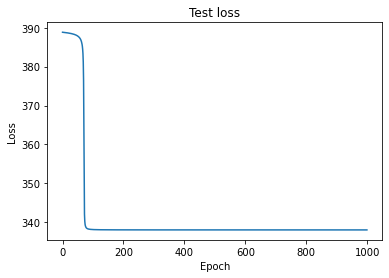

In [58]:
import matplotlib.pyplot as plt

plt.plot(test_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test loss')
plt.show()

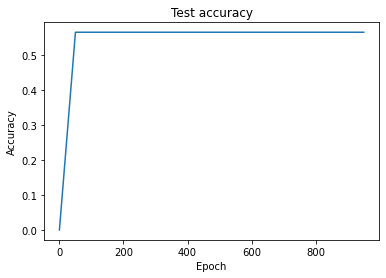

In [59]:
plt.plot(range(0,1000,50),test_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test accuracy')
plt.show()

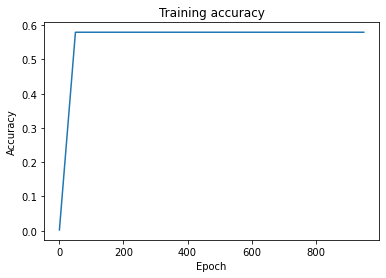

In [60]:
plt.plot(range(0,1000,50), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.show()

## Neural Net - Architecture 2

In [87]:
class Mnist_Logistic2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(47, 40)
        self.lin2 = nn.Linear(40, nact)

    def forward(self, xb):
        xb = F.leaky_relu(self.lin1(xb))
        xb = F.softmax(self.lin2(xb), dim=1)
        return xb

In [88]:
def get_model2():
    model = Mnist_Logistic2()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [81]:
model, opt = get_model2()
test_loss = []
test_acc = []
train_acc = []
logging.info('Starting training - model 2')

for epoch in range(1000):
    logging.info('Epoch: ' + str(epoch))
    model.train()
    for xb, yb in train_dl:
        pred = model(xb.float())
        loss = loss_func(pred, yb.long())

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb.float()), yb.long()) for xb, yb in test_dl)
        test_loss.append(valid_loss)
        if epoch % 50 == 0:
            test_acc.append(accuracy(test_dl))
            train_acc.append(accuracy(train_dl))

logging.info('Training finished')
print(loss_func(model(xb.float()), yb.long()))


tensor(2.3901, grad_fn=<NllLossBackward>)


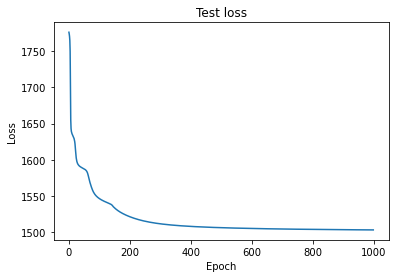

In [82]:
import matplotlib.pyplot as plt

plt.plot(test_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test loss')
plt.show()

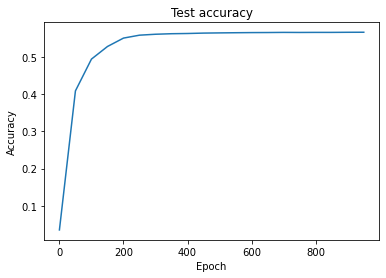

In [83]:
plt.plot(range(0,1000,50),test_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test accuracy')
plt.show()

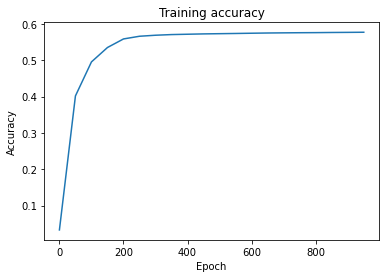

In [85]:
plt.plot(range(0,1000,50), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.show()

## Neural Net - Architecture 3

In [86]:
class Mnist_Logistic3(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(47, 50)
        self.lin2 = nn.Linear(50, 50)
        self.lin3 = nn.Linear(50, 50)
        self.lin4 = nn.Linear(50, nact)


    def forward(self, xb):
        xb = F.leaky_relu(self.lin1(xb))
        xb = F.leaky_relu(self.lin2(xb))
        xb = F.leaky_relu(self.lin3(xb))
        xb = F.softmax(self.lin4(xb), dim=1)
        return xb

In [89]:
def get_model3():
    model = Mnist_Logistic3()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [ ]:
model, opt = get_model3()
test_loss = []
test_acc = []
train_acc = []
logging.info('Starting training - model 3')

for epoch in range(1000):
    logging.info('Epoch: ' + str(epoch))
    model.train()
    for xb, yb in train_dl:
        pred = model(xb.float())
        loss = loss_func(pred, yb.long())

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb.float()), yb.long()) for xb, yb in test_dl)
        test_loss.append(valid_loss)
        if epoch % 50 == 0:
            test_acc.append(accuracy(test_dl))
            train_acc.append(accuracy(train_dl))

logging.info('Training finished')
print(loss_func(model(xb.float()), yb.long()))

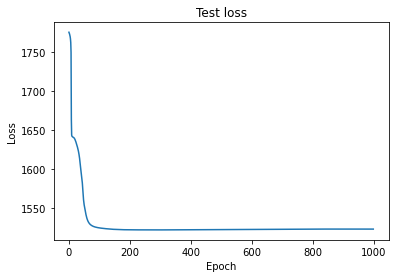

In [94]:
import matplotlib.pyplot as plt

plt.plot(test_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test loss')
plt.show()

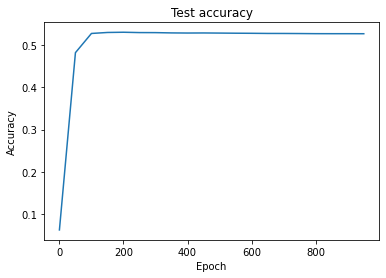

In [95]:
plt.plot(range(0,1000,50),test_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test accuracy')
plt.show()

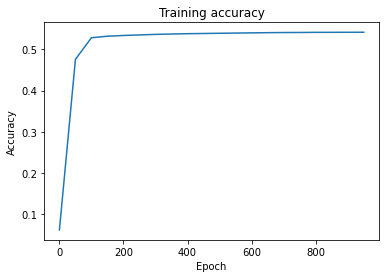

In [96]:
plt.plot(range(0,1000,50), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training accuracy')
plt.show()